# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import os
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
import numpy as np
import pandas as pd
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper, 
    MonetaryLiquidator, 
    MonetarySniper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.data_collection import (
    DataCollectionOptions, 
    HDF5DataCollectionFile
)

from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
)

from ovm.monetary.plots import (
    DEFAULT_FIGURE_SIZE, 
    convert_time_in_seconds_to_index, 
    convert_time_interval_in_seconds_to_indices, 
    construct_full_time_axis, 
    construct_time_axis, 
    get_indices_and_time_axis_to_plot, 
    plot_multiple_variables_over_time, 
    plot_price_deviations, 
    plot_skews, 
    plot_single_variable_over_time, 
    plot_single_variable_over_time_from_numpy_array, 
    plot_supply, 
    plot_treasury, 
    plot_liquidity, 
    plot_spot_vs_futures_price, 
    plot_open_positions
)

from ovm.monetary.reporters import * 
from ovm.monetary.data_io import (
    construct_sims_map, 
    construct_ticker_to_series_of_prices_map_from_simulated_prices, 
    construct_ticker_to_series_of_prices_map_from_historical_prices, 
    load_and_construct_ticker_to_series_of_prices_map_from_historical_prices, 
    construct_abs_data_input_with_historical_data
)

from ovm.paths import (
    HistoricalDataSource, 
    construct_historical_data_directory
)

from ovm.simulation.bootstrap import plot_multivariate_simulation
from ovm.simulation.resampling import (
    load_log_returns,
    simulate_new_price_series_via_bootstrap,
    store_simulated_price_series_in_output_directory
)

from ovm.tickers import (
    EOS_ETH_TICKER,
    ETC_ETH_TICKER,
    MKR_ETH_TICKER,
    SNX_ETH_TICKER,
    XRP_ETH_TICKER,
    ETH_TICKER,
    get_ovl_quote_ticker,
)

from ovm.time_resolution import (
    TimeResolution, 
    TimeScale
)

environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /Volumes/GIT/PycharmProjects/overlay-monetary
environment variable OVERLAY_MONETARY_INPUT_BASE_PATH not set defaulting to /Volumes/GIT/PycharmProjects/overlay-monetary


In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
historical_data_source = HistoricalDataSource.KUCOIN
time_resolution = TimeResolution.ONE_MINUTE
numpy_seed = 42
np.random.seed(numpy_seed)

# # run agent based simulations for 24 hours
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_days_to_number_of_steps(1.0)

# run agent based simulations for 7 days
number_of_steps_to_simulate = \
    time_resolution.convert_time_in_days_to_number_of_steps(7.0)

# # run agent based simulations for 2 years
# number_of_steps_to_simulate = \
#     time_resolution.convert_time_in_years_to_number_of_steps(2.0)

print(f'number_of_steps_to_simulate={number_of_steps_to_simulate}')

directory_path = \
    construct_historical_data_directory(
        historical_data_source=historical_data_source, 
        time_resolution=time_resolution)

# Load sims from csv files as arrays
tickers = [EOS_ETH_TICKER,
           ETC_ETH_TICKER,
           MKR_ETH_TICKER,
           SNX_ETH_TICKER,
           XRP_ETH_TICKER]

ovl_ticker = SNX_ETH_TICKER  # for sim source, since OVL doesn't actually exist yet
quote_ticker = ETH_TICKER
ovl_quote_ticker = get_ovl_quote_ticker(quote_ticker)

tickers_with_ovl = [ovl_quote_ticker if ticker == ovl_ticker else ticker for ticker in tickers]
tickers_with_ovl

number_of_steps_to_simulate=10080


['EOS-ETH', 'ETC-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH']

# Load Historical Data

In [8]:
input_data = \
    construct_abs_data_input_with_historical_data(
            time_resolution=time_resolution,
            historical_data_source=historical_data_source,
            tickers=tickers,
            ovl_ticker=ovl_ticker,
            ovl_quote_ticker=ovl_quote_ticker)

In [9]:
input_data.tickers

('EOS-ETH', 'ETC-ETH', 'MKR-ETH', 'OVL-ETH', 'XRP-ETH')

# Construct Agent Based Monetary Model

In [10]:
total_supply = 100000  # OVL
base_wealth = 0.0005*total_supply  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
base_liquidate_reward = 0.1
base_maintenance = 0.6
liquidity = 0.285*total_supply
time_liquidity_mine = time_resolution.steps_per_month_clamped
treasury = 0.0
sampling_interval = int(3600 / time_resolution.in_seconds)
sampling_twap_granularity = int(
    sampling_interval / 10)

num_arbitrageurs = int(total_supply*0.1/base_wealth)
num_long_apes = int(total_supply*0.035/base_wealth)
num_short_apes = int(total_supply*0.015/base_wealth)
num_keepers = int(total_supply*0.005/base_wealth)
num_traders = int(total_supply*0.005/base_wealth)
num_holders = int(total_supply*0.5/base_wealth)
num_snipers = int(total_supply*0.05/base_wealth)
num_liquidators = int(total_supply*0.005/base_wealth)
num_agents = num_arbitrageurs + num_keepers + \
    num_traders + num_holders + num_snipers + num_liquidators

data_collection_options = \
    DataCollectionOptions(compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False, 
                          use_hdf5=True)

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  num_snipers=num_snipers, 
                  num_long_apes=num_long_apes, 
                  num_short_apes=num_short_apes,
                  num_liquidators=num_liquidators, 
                  base_maintenance=base_maintenance, 
                  base_liquidate_reward=base_liquidate_reward, 
                  input_data=input_data, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  sampling_twap_granularity=sampling_twap_granularity,
                  data_collection_options=data_collection_options, 
                  quote_ticker=quote_ticker, 
#                   ovl_quote_ticker=ovl_quote_ticker, 
#                   time_resolution=time_resolution, 
                  seed=0)

print("Model kwargs for initial conditions of sim:")
print(f"num_arbitrageurs = {num_arbitrageurs}")
print(f"num_snipers = {num_snipers}")
print(f"num_keepers = {num_keepers}")
print(f"num_traders = {num_traders}")
print(f"num_holders = {num_holders}")
print(f"num_liquidators = {num_liquidators}")
print(f"total number of agents = {num_agents}")
print(f"base_wealth = {base_wealth}")

quote_ticker=ETH
num_arbitrageurs=200
num_keepers=10
num_traders=10
num_holders=1000
num_snipers=100
num_long_apes=70
num_short_apes=30
num_liquidators=10
base_wealth=50.0
base_market_fee=0.003
base_max_leverage=10.0
base_liquidate_reward=0.1
base_maintenance=0.6
liquidity=28499.999999999996
treasury=0.0
sampling_interval=60
sampling_twap_granularity=6
time_resolution=1m
historical_data_source=kucoin
ovl_ticker=SNX-ETH
ovl_quote_ticker=OVL-ETH
numpy_seed=None
is_resampled=False
data_collection_interval=1
Model kwargs for initial conditions of sim:
num_arbitrageurs = 200
num_snipers = 100
num_keepers = 10
num_traders = 10
num_holders = 1000
num_liquidators = 10
total number of agents = 1330
base_wealth = 50.0


In [11]:
# # Constants
# STEPS_MONTH = int((86400*30)/time_resolution.in_seconds)

# total_supply = 100000  # OVL
# # base_wealth = 0.0002*100000  # OVL
# base_wealth = 0.001*100000  # OVL
# base_market_fee = 0.0030
# base_max_leverage = 10.0
# base_liquidate_reward = 0.1
# base_maintenance = 0.6
# liquidity = 0.285*total_supply
# time_liquidity_mine = STEPS_MONTH
# treasury = 0.0
# sampling_interval = int(3600/time_resolution.in_seconds)

# # num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 100)
# num_arbitrageurs = min(int(total_supply*0.1/base_wealth), 50)
# num_keepers = int(total_supply*0.005/base_wealth)
# # num_traders = int(total_supply*0.005/base_wealth)
# num_traders = 0
# # num_holders = int(total_supply*0.5/base_wealth)
# num_holders = 0
# # num_snipers = min(int(total_supply*0.1/base_wealth), 100)
# num_snipers = min(int(total_supply*0.1/base_wealth), 50)
# # num_liquidators = int(total_supply*0.005/base_wealth)
# num_liquidators = 4 * (len(tickers) + 1)
# num_agents = num_arbitrageurs + num_keepers + \
#     num_traders + num_holders + num_snipers + num_liquidators

# DATA_COLLECTOR_NAME = 'data_collector'
# data_collection_options = \
#     DataCollectionOptions(compute_gini_coefficient=False,
#                           compute_wealth=False,
#                           compute_inventory_wealth=False, 
#                           use_hdf5=True)

# # For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
# liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
#                              for i
#                              in range(time_liquidity_mine)]

# monetary_model = \
#     MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
#                   num_keepers=num_keepers, 
#                   num_traders=num_traders, 
#                   num_holders=num_holders, 
#                   num_snipers=num_snipers, 
#                   num_liquidators=num_liquidators, 
#                   base_maintenance=base_maintenance, 
#                   base_liquidate_reward=base_liquidate_reward, 
#                   input_data=input_data, 
#                   base_wealth=base_wealth, 
#                   base_market_fee=base_market_fee, 
#                   base_max_leverage=base_max_leverage, 
#                   liquidity=liquidity, 
#                   liquidity_supply_emission=liquidity_supply_emission, 
#                   treasury=treasury, 
#                   sampling_interval=sampling_interval, 
#                   data_collection_options=data_collection_options, 
#                   quote_ticker=quote_ticker, 
#                   ovl_quote_ticker=ovl_quote_ticker, 
#                   time_resolution=time_resolution, 
#                   seed=0)

# print("Model kwargs for initial conditions of sim:")
# print(f"num_arbitrageurs = {num_arbitrageurs}")
# print(f"num_snipers = {num_snipers}")
# print(f"num_keepers = {num_keepers}")
# print(f"num_traders = {num_traders}")
# print(f"num_holders = {num_holders}")
# print(f"num_liquidators = {num_liquidators}")
# print(f"total number of agents = {num_agents}")
# print(f"base_wealth = {base_wealth}")

Drastically reduced the number of traders and holders to bring down the memory requirement for storing agent wealth (with the original numbers it would have been 7500 agents total). This would exceed the 128GB mem of my machine with 200000 steps

# Run Simulation

In [12]:
# def run_model(number_of_steps_to_simulate: int, use_tqdm: bool = True):
#     run_range = range(number_of_steps_to_simulate + 1)
#     if use_tqdm:
#         run_range = tqdm(run_range)

#     try: 
#         for i in run_range:
#             monetary_model.step()
#     finally:
#         print('end')


In [13]:
# number_of_steps_to_simulate = 1000

In [14]:
number_of_steps_to_simulate

10080

In [15]:
monetary_model.run_steps(number_of_steps_to_simulate, use_tqdm=True)

100%|██████████| 10081/10081 [00:28<00:00, 353.42it/s]


In [16]:
for market_name, market in monetary_model.fmarkets.items():
    print(f'open positions on {market_name} = {len(market.positions)}')

open positions on EOS-ETH = 168
open positions on ETC-ETH = 742
open positions on MKR-ETH = 805
open positions on OVL-ETH = 169
open positions on XRP-ETH = 219


In [17]:
monetary_model.run_steps(500, use_tqdm=True)

100%|██████████| 501/501 [00:01<00:00, 330.46it/s]


In [18]:
# hdf5_model_variables = monetary_model.data_collector.hdf5_file.get('MODEL_VARIABLES')

In [19]:
# [len(dataset) for name, dataset in hdf5_model_variables.items()]

In [20]:
# df = pd.DataFrame({name: np.array(dataset) for name, dataset in hdf5_model_variables.items()})
# df.tail()

In [21]:
# len(df)

# Extract Model Variables

Model Level Variables Collected During Simulation

In [22]:
monetary_model.data_collector.model_reporter_names

('d-EOS-ETH',
 'd-ETC-ETH',
 'd-MKR-ETH',
 'd-OVL-ETH',
 'd-XRP-ETH',
 's-EOS-ETH',
 's-ETC-ETH',
 's-MKR-ETH',
 's-OVL-ETH',
 's-XRP-ETH',
 'f-EOS-ETH',
 'f-ETC-ETH',
 'f-MKR-ETH',
 'f-OVL-ETH',
 'f-XRP-ETH',
 'Skew EOS-ETH',
 'Skew ETC-ETH',
 'Skew MKR-ETH',
 'Skew OVL-ETH',
 'Skew XRP-ETH',
 'Reserve Skew EOS-ETH (% Difference)',
 'Reserve Skew ETC-ETH (% Difference)',
 'Reserve Skew MKR-ETH (% Difference)',
 'Reserve Skew OVL-ETH (% Difference)',
 'Reserve Skew XRP-ETH (% Difference)',
 'Number of Open Positions on EOS-ETH',
 'Number of Open Positions on ETC-ETH',
 'Number of Open Positions on MKR-ETH',
 'Number of Open Positions on OVL-ETH',
 'Number of Open Positions on XRP-ETH',
 'Supply',
 'Treasury',
 'Liquidity')

In [23]:
# monetary_model.data_collector.hdf5_file['d-EOS-ETH']

In [24]:
# [dataset.shape for dataset in monetary_model.data_collector._model_reporter_collection.datasets]

Getting the model vars df takes 53ms

In [25]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()

In [26]:
model_vars_df.head()

,d-EOS-ETH,d-ETC-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-ETC-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,...,Reserve Skew XRP-ETH (% Difference),Number of Open Positions on EOS-ETH,Number of Open Positions on ETC-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity,step
0,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0,0
1,0.813454,7.392695e-01,-5.743150e-04,0.176471,1.239088e-16,0.014999,0.050021,3.70807,0.000850,0.003500,...,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0,1
2,0.701636,4.500599e-01,-4.727926e-02,0.078656,2.806401e-01,0.014999,0.050020,3.65000,0.000988,0.002913,...,0.065712,1,1,1,1,1,99999.010418,0.989582,28500.0,2
3,0.874553,2.477458e-02,3.635085e-03,0.071711,1.992453e-01,0.012801,0.075880,3.70000,0.000931,0.002913,...,-0.002022,2,2,2,2,2,99998.297918,1.702082,28500.0,3
4,0.779721,1.493379e-01,-2.085565e-01,-0.050201,-1.805612e-01,0.012700,0.050203,5.00000,0.000986,0.004000,...,-0.063499,3,3,3,3,3,99996.977918,3.022082,28500.0,4


In [27]:
len(model_vars_df)

10581

In [28]:
# model_vars_df.to_parquet('model_vars.parq')

In [29]:
model_vars_df.memory_usage(deep=True)

Index                                    128
d-EOS-ETH                              84648
d-ETC-ETH                              84648
d-MKR-ETH                              84648
d-OVL-ETH                              84648
d-XRP-ETH                              84648
s-EOS-ETH                              84648
s-ETC-ETH                              84648
s-MKR-ETH                              84648
s-OVL-ETH                              84648
s-XRP-ETH                              84648
f-EOS-ETH                              84648
f-ETC-ETH                              84648
f-MKR-ETH                              84648
f-OVL-ETH                              84648
f-XRP-ETH                              84648
Skew EOS-ETH                           84648
Skew ETC-ETH                           84648
Skew MKR-ETH                           84648
Skew OVL-ETH                           84648
Skew XRP-ETH                           84648
Reserve Skew EOS-ETH (% Difference)    84648
Reserve Sk

In [30]:
model_vars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10581 entries, 0 to 10580
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   d-EOS-ETH                            10581 non-null  float64
 1   d-ETC-ETH                            10581 non-null  float64
 2   d-MKR-ETH                            10581 non-null  float64
 3   d-OVL-ETH                            10581 non-null  float64
 4   d-XRP-ETH                            10581 non-null  float64
 5   s-EOS-ETH                            10581 non-null  float64
 6   s-ETC-ETH                            10581 non-null  float64
 7   s-MKR-ETH                            10581 non-null  float64
 8   s-OVL-ETH                            10581 non-null  float64
 9   s-XRP-ETH                            10581 non-null  float64
 10  f-EOS-ETH                            10581 non-null  float64
 11  f-ETC-ETH                   

In [31]:
# model_vars_df.head()

In [32]:
# fig = px.line(model_vars_df, y="Supply", title='OVL Supply')
# fig = px.line(model_vars_df, y="Treasury", title='Treasury')
# fig.show()


# Extract Wealth

In [33]:
# def convert_time_in_seconds_to_index(
#     time_resolution: TimeResolution, 
#     time_in_seconds: float):
#     return int(np.floor(time_in_seconds / time_resolution.in_seconds))

In [34]:
quarter_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 / 4.0 * 24 * 60 * 60)
quarter_year_index

131490

In [35]:
one_year_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=365.25 * 24 * 60 * 60)
one_year_index

525960

In [36]:
one_day_index = \
    convert_time_in_seconds_to_index(
        time_resolution=time_resolution, 
        time_in_seconds=24 * 60 * 60)
one_day_index

1440

In [37]:
525960 / monetary_model.schedule.steps

49.703269703269704

In [38]:
monetary_model.schedule.steps / 4 / 60 / 24

1.8371527777777779

In [39]:
# type(monetary_model.data_collector._agent_records)

In [40]:
# def extract_agent_vars_for_time_step(monetary_model: MonetaryModel, time_step: int):
#     agent_vars_for_time_step = \
#         monetary_model.data_collector._agent_records[time_step]
#     column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
    
#     return pd.DataFrame(data=agent_vars_for_time_step, columns=column_names)

In [41]:
# column_names = ['time_step', 'agent_id'] + list(monetary_model.data_collector.agent_reporters.keys())
# column_names

In [42]:
# monetary_model.data_collector.agent_reporters

In [43]:
# df = \
#     extract_agent_vars_for_time_step(monetary_model, quarter_year_index)
# df.to_csv(f'agent_wealth_after_{quarter_year_index}_time_steps.csv')

In [44]:
# monetary_model.data_collector._agent_records[quarter_year_index]

# Extract Agent Variables

Agent Level Variables Collected During Simulation

In [45]:
monetary_model.data_collector.agent_reporter_names

('Wealth',)

Plot wealth distribution for each agent type

Getting all of these dfs takes 765ms

In [46]:
for agent_type in monetary_model.data_collector.agent_type_set:
    wealth_df_for_agent_type = \
        monetary_model.data_collector.get_agent_report_dataframe('Wealth', 
                                                                 use_agent_types_in_header=True, 
                                                                 agent_type=agent_type)

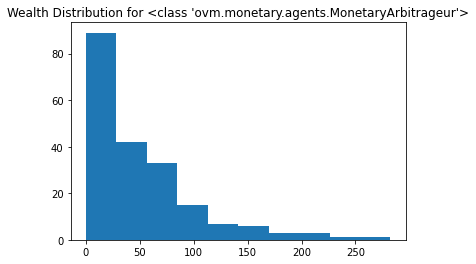

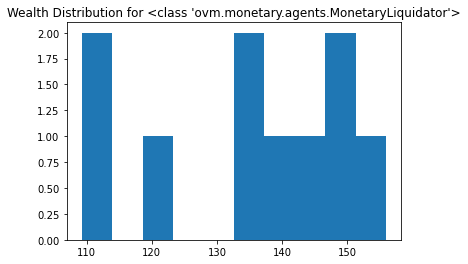

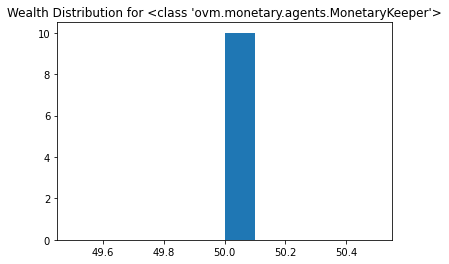

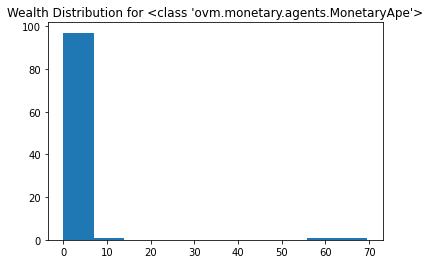

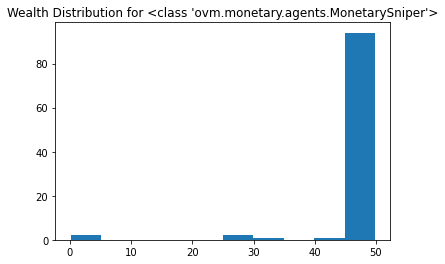

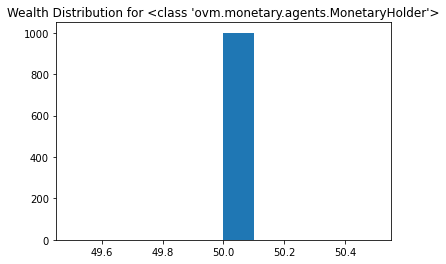

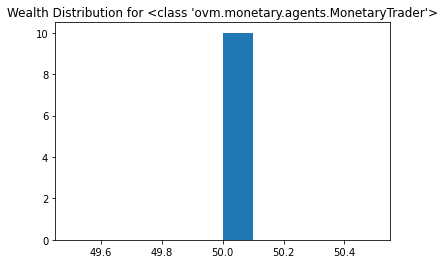

In [47]:
for agent_type in monetary_model.data_collector.agent_type_set:
    wealth_df_for_agent_type = \
        monetary_model.data_collector.get_agent_report_dataframe('Wealth', 
                                                                 use_agent_types_in_header=True, 
                                                                 agent_type=agent_type)
    plt.figure();
    plt.hist(wealth_df_for_agent_type.iloc[-1, :]);
    plt.title(f'Wealth Distribution for {agent_type}')

Wealth Dataframe for all Agent Types

The getting this agent report df takes 99ms

In [48]:
wealth_df = \
    monetary_model.data_collector.get_agent_report_dataframe('Wealth', 
                                                             use_agent_types_in_header=True)

In [49]:
wealth_df.tail()

,MonetaryArbitrageur-0,MonetaryArbitrageur-1,MonetaryArbitrageur-2,MonetaryArbitrageur-3,MonetaryArbitrageur-4,MonetaryArbitrageur-5,MonetaryArbitrageur-6,MonetaryArbitrageur-7,MonetaryArbitrageur-8,MonetaryArbitrageur-9,...,MonetaryApe-1420,MonetaryApe-1421,MonetaryApe-1422,MonetaryApe-1423,MonetaryApe-1424,MonetaryApe-1425,MonetaryApe-1426,MonetaryApe-1427,MonetaryApe-1428,MonetaryApe-1429
10576,1.900844,4.387515,99.230666,26.469997,0.153007,1.844918,0.020987,79.255429,20.129612,63.502922,...,2.592659,0.0,0.0,4.387065,2.855235,0.0,69.592262,0.645775,0.0,1.989522
10577,1.900844,4.387515,99.230666,26.469997,0.153007,1.844918,0.020987,79.255429,20.129612,63.502922,...,2.592659,0.0,0.0,4.387065,2.855235,0.0,69.592262,0.645775,0.0,0.000000
10578,1.900844,4.387515,99.230666,26.469997,0.153007,1.844918,0.020987,79.255429,20.129612,63.502922,...,2.592659,0.0,0.0,4.387065,2.855235,0.0,69.592262,0.645775,0.0,0.000000
10579,1.900844,4.387515,99.230666,26.469997,0.153007,1.834401,0.020987,79.255429,20.129612,63.502922,...,2.592659,0.0,0.0,4.387065,2.855235,0.0,69.592262,0.645775,0.0,0.000000
10580,1.900844,4.387515,99.230666,26.469997,0.153007,1.834401,0.020987,79.255429,20.129612,63.502922,...,2.592659,0.0,0.0,4.387065,2.855235,0.0,69.592262,0.645775,0.0,0.000000


Wealth Distribution for all Agent Types

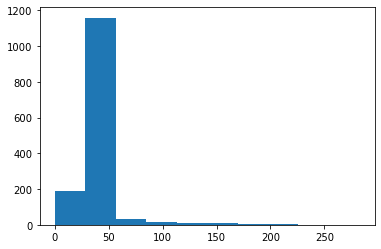

In [50]:
plt.hist(wealth_df.iloc[-1, :]);

In [51]:
# monetary_model.data_collector.__dict__

In [52]:
# agent_vars_df = monetary_model.data_collector.get_agent_vars_dataframe()
# print(len(agent_vars_df))

In [53]:
# agent_vars_df.to_csv(f'agent_vars.csv')

In [54]:
# agent_vars_df.to_parquet(f'agent_vars.parq')

In [55]:
# agent_vars_df.info()

In [56]:
# agent_vars_df.tail(300)

In [57]:
# agent_vars_df.loc[(699999, 1), :]
# df.loc[('cobra', 'mark i'), 'shield']

In [58]:
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_year_index, :], :].values
# agent_wealth = agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values

In [59]:
# agent_wealth.shape

In [60]:
# agent_wealth.sum()

In [61]:
# def arbitrageur_indices():
#     return 0, num_arbitrageurs


# def keeper_indices():
#     return num_arbitrageurs, num_arbitrageurs+num_keepers


# def sniper_indices():
#     begin_index = num_arbitrageurs + num_keepers + num_holders + num_traders
#     end_index = num_arbitrageurs + num_keepers + num_holders + num_traders + num_snipers
#     return begin_index, end_index

In [62]:
# sorted(agent_wealth[sniper_indices()[0]:sniper_indices()[1]])

In [63]:
# sorted(agent_wealth[keeper_indices()[0]:keeper_indices()[1]])

In [64]:
# sorted(agent_wealth[arbitrageur_indices()[0]:arbitrageur_indices()[1]])

In [65]:
# histogram = plt.hist(agent_vars_df.loc[pd.IndexSlice[one_day_index, :], :].values)

In [66]:
# sns.kdeplot(data=agent_wealth);

# Plot Results

## New Plots with 100 Arbitrageurs and 100 Snipers (no traders and no holders)

In [67]:
plot_time_scale = TimeScale.YEARS

### Set Plot Horizon in Seconds

In [68]:
plot_begin_years = 0.0
# plot_end_years = 5 * 365.25 * 24 * 60 * 60  # 5 years
# plot_end_years = 0.75 * 365.25 * 24 * 60 * 60  # 9 months
plot_end_years = 1 * 365.25 * 24 * 60 * 60  # 1 year
time_interval_to_plot_in_seconds = (plot_begin_years, plot_end_years)
time_interval_to_plot_in_seconds = None

### OVL Supply

In [69]:
# def convert_time_index_to_time_in_seconds(
#     time_step: int, 
#     time_resolution: TimeResolution) -> float:
#     return time_step * time_resolution.in_seconds

In [70]:
# convert_time_index_to_time_in_seconds(
#     model_vars_df.index.values[-1], 
#     time_resolution=time_resolution)

634800

In [71]:
# time_resolution.convert_steps_to_time_scale(steps=model_vars_df.index.values[-1], time_scale=TimeScale.SECONDS)

634800.0

In [72]:
# def express_time_index_in_time_scale(
#     time_step: int, 
#     time_resolution: TimeResolution, 
#     time_scale: TimeScale) -> float:
#     return time_step * time_resolution.in_seconds / time_scale.in_seconds()

In [73]:
# express_time_index_in_time_scale(
#     model_vars_df.index.values[-1], 
#     time_resolution=time_resolution, 
#     time_scale=TimeScale.YEARS)

0.02011559814434558

In [98]:
# time_resolution.convert_steps_to_time_scale(steps=model_vars_df.index.values[-1], time_scale=TimeScale.YEARS)

0.02011559814434558

Initial OVL Supply

In [74]:
model_vars_df.loc[:, SUPPLY_LABEL].values[0]

100000.0

Final OVL Supply

In [75]:
model_vars_df.loc[:, SUPPLY_LABEL].values[-1]

91874.05219628282

OVL Growth in % over simulation timeframe

In [76]:
(model_vars_df.loc[:, SUPPLY_LABEL].values[-1] / model_vars_df.loc[:, SUPPLY_LABEL].values[0] - 1) * 100

-8.125947803717182

Important: After the spike, the OVL supply does not go back to its initial level but increases from 41000 to to 54.6 million.

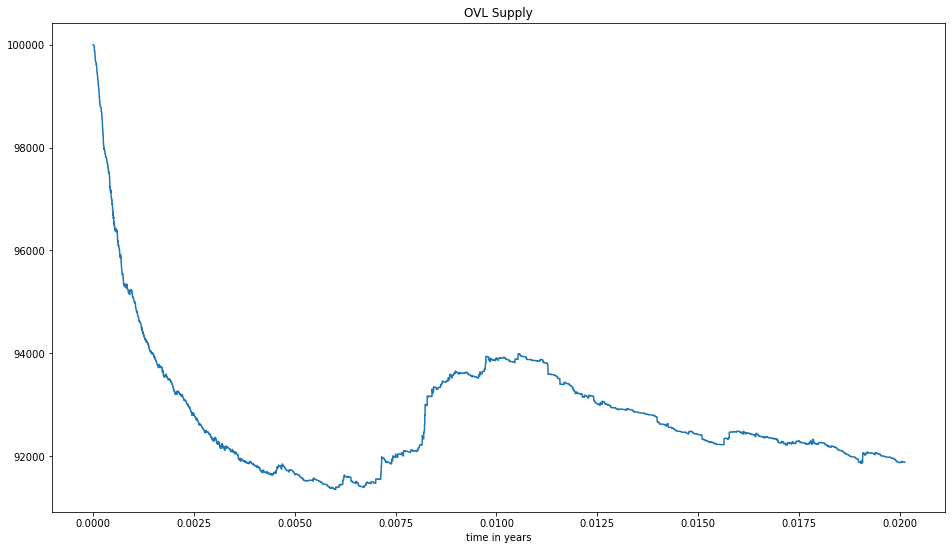

In [77]:
plot_supply(model_vars_df=model_vars_df, 
            plot_time_scale=plot_time_scale, 
            time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
            time_resolution=time_resolution, 
            data_interval=data_collection_options.data_collection_interval)

### Liquidity

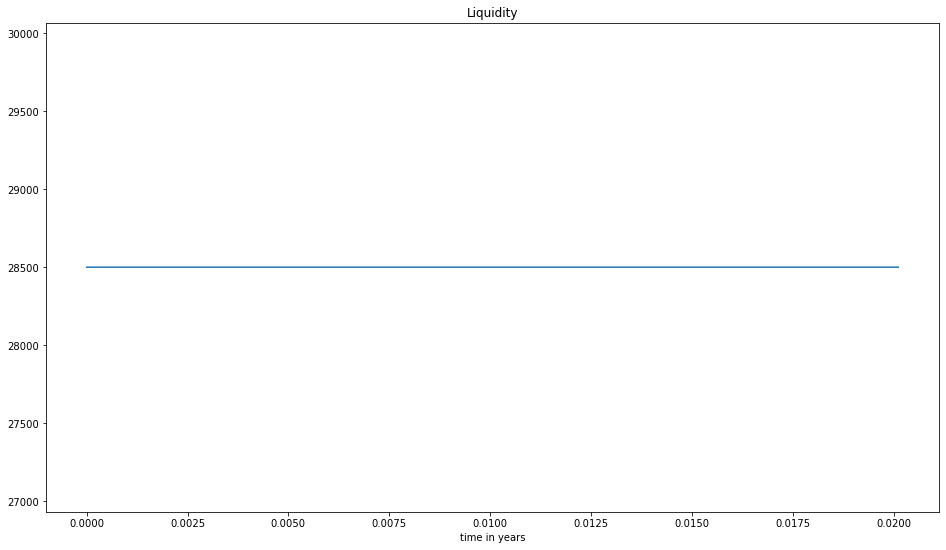

In [78]:
plot_liquidity(model_vars_df=model_vars_df,  
               plot_time_scale=plot_time_scale, 
               time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
               time_resolution=time_resolution, 
               data_interval=data_collection_options.data_collection_interval)

### Treasury

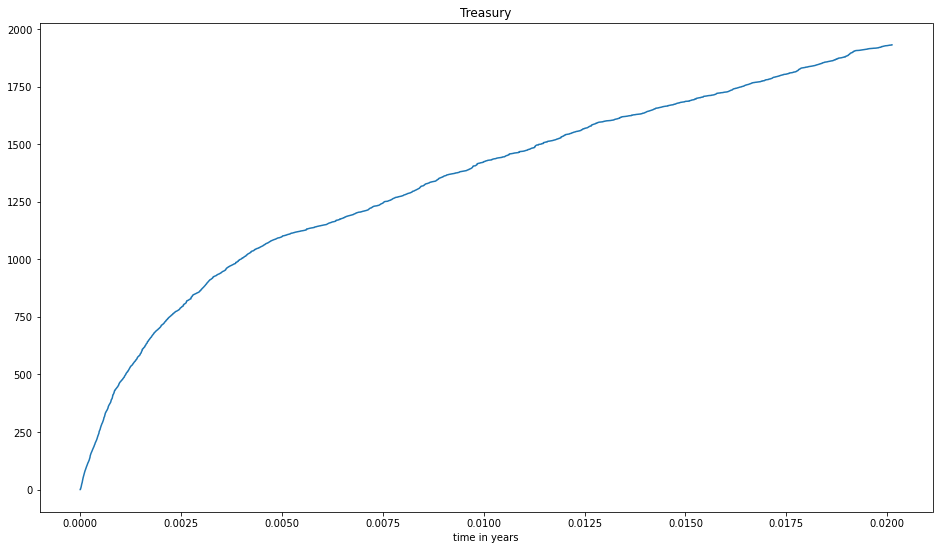

In [79]:
plot_treasury(model_vars_df=model_vars_df, 
              plot_time_scale=plot_time_scale, 
              time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
              time_resolution=time_resolution, 
              data_interval=data_collection_options.data_collection_interval)

### Price Deviations

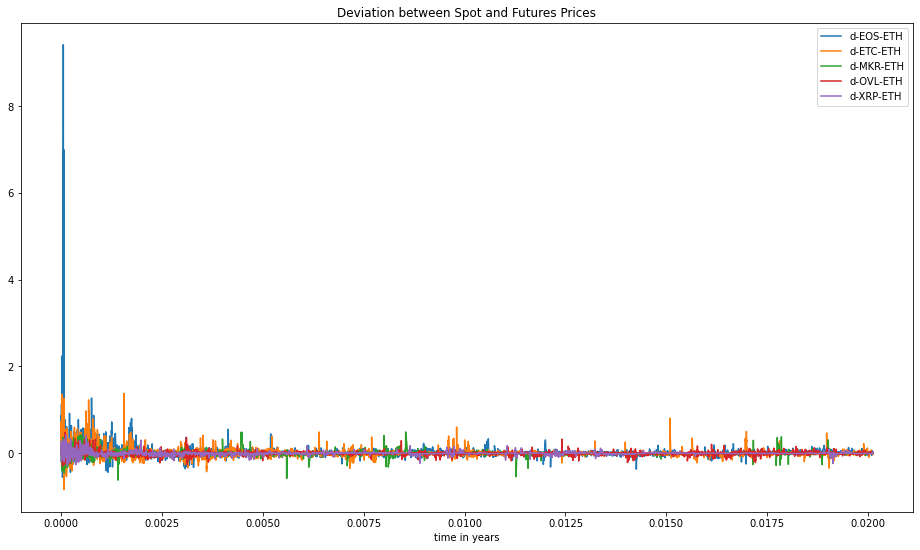

In [80]:
plot_price_deviations(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Open Positions

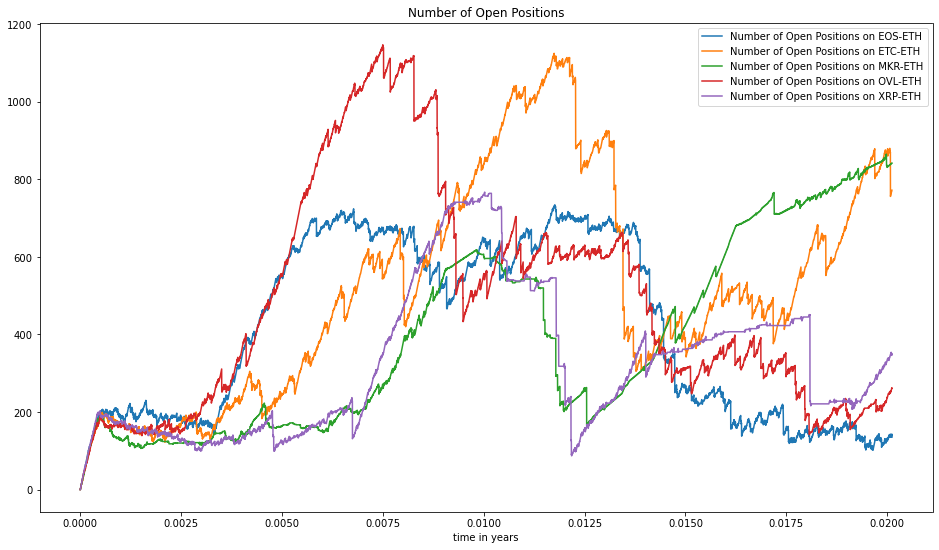

In [81]:
plot_open_positions(
    model_vars_df=model_vars_df, 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

### Skew

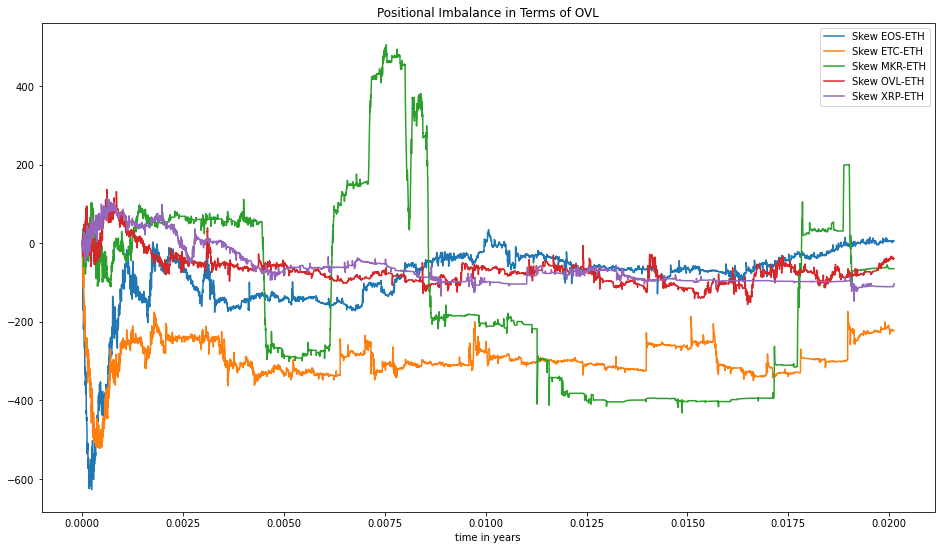

In [82]:
plot_skews(
    model_vars_df=model_vars_df, 
#     tickers=tickers_with_ovl[1:], 
    tickers=tickers_with_ovl, 
    plot_time_scale=plot_time_scale, 
    time_resolution=time_resolution, 
    time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
    data_interval=data_collection_options.data_collection_interval)

#### Correlation between Skew and Futures Price

In [83]:
for i, ticker in enumerate(tickers_with_ovl):
    if i > 0:
        break
    skew = model_vars_df.loc[:, skew_label(ticker)].values
    futures_price = model_vars_df.loc[:, futures_price_label(ticker)].values
    spot_price = model_vars_df.loc[:, spot_price_label(ticker)].values
    print(np.corrcoef(skew, futures_price))
    print(np.corrcoef(skew, spot_price))

[[1.         0.21315024]
 [0.21315024 1.        ]]
[[1.         0.31933278]
 [0.31933278 1.        ]]


### Cumulative Returns

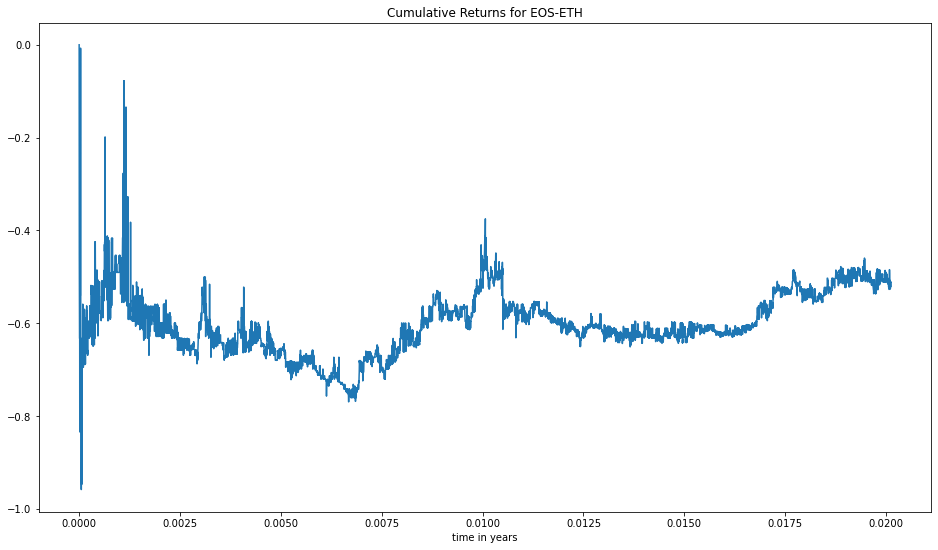

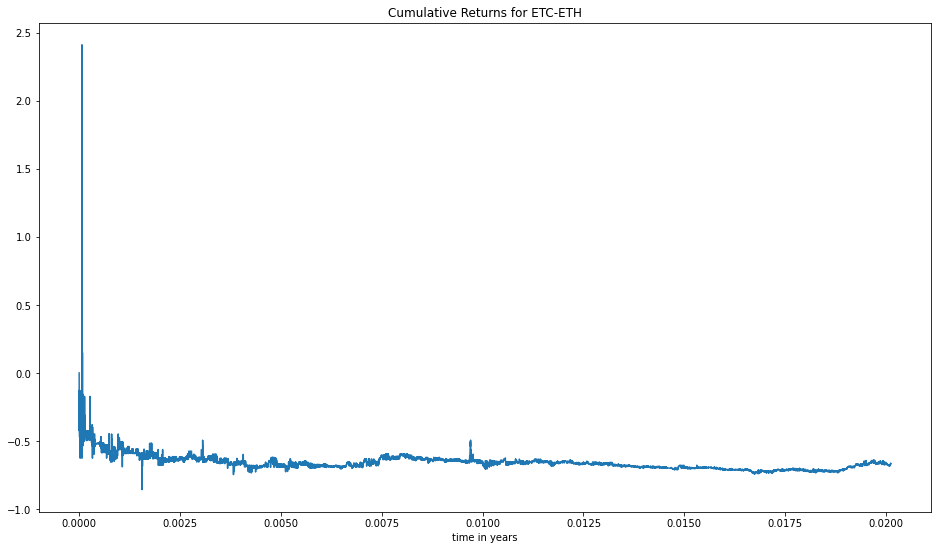

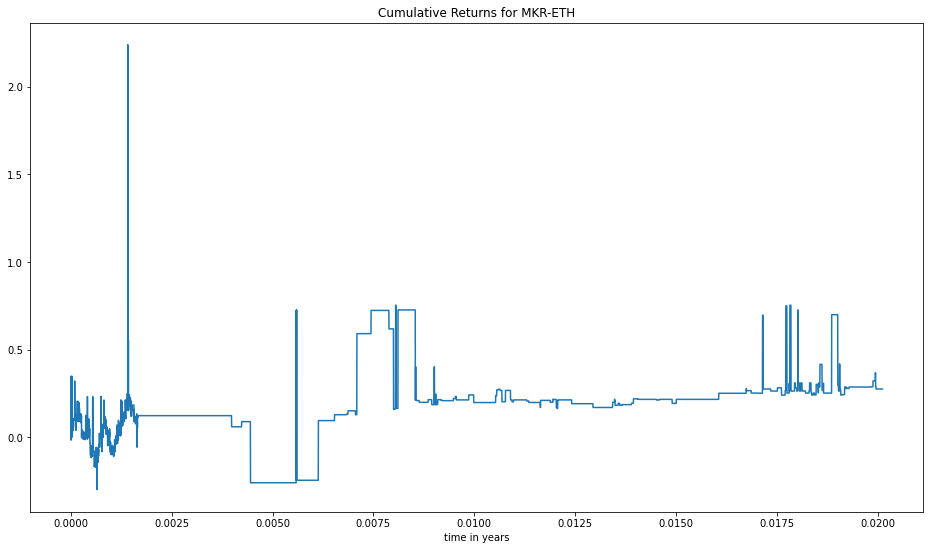

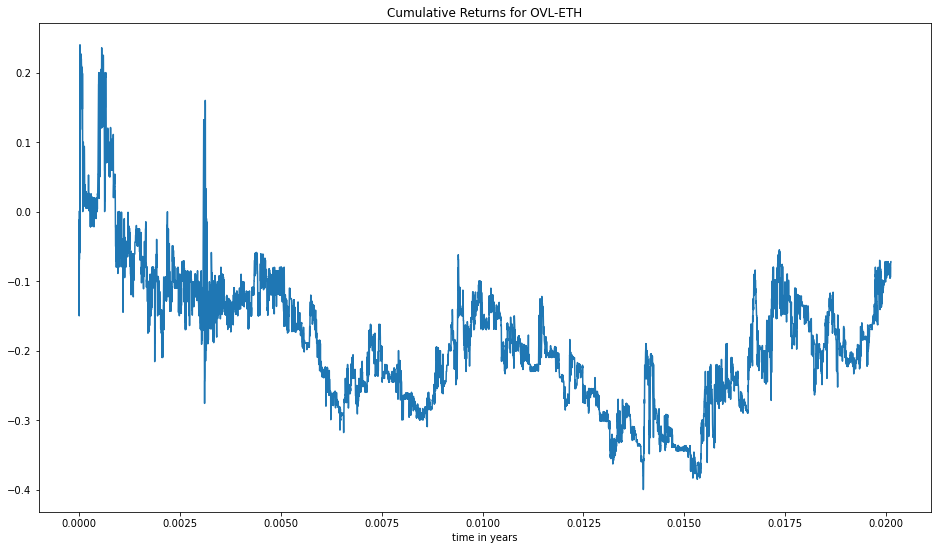

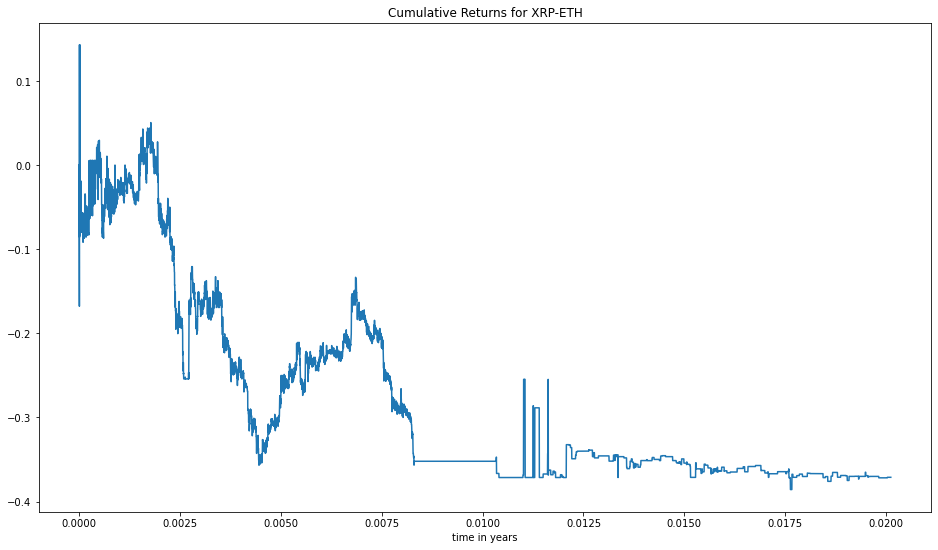

In [84]:
for i, ticker in enumerate(tickers_with_ovl):
    spot_prices_for_ticker = model_vars_df.loc[:, spot_price_label(ticker)].values
    cumulative_return_for_ticker = spot_prices_for_ticker / spot_prices_for_ticker[0] - 1.0
    
    plot_single_variable_over_time_from_numpy_array(
        array=cumulative_return_for_ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)
    
    plt.title(f'Cumulative Returns for {ticker}')

### Spot vs. Futures Prices

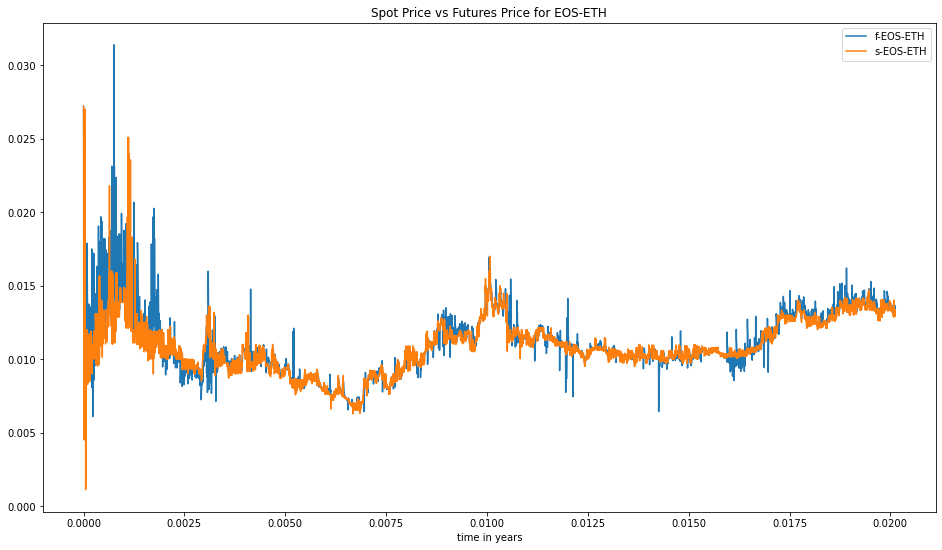

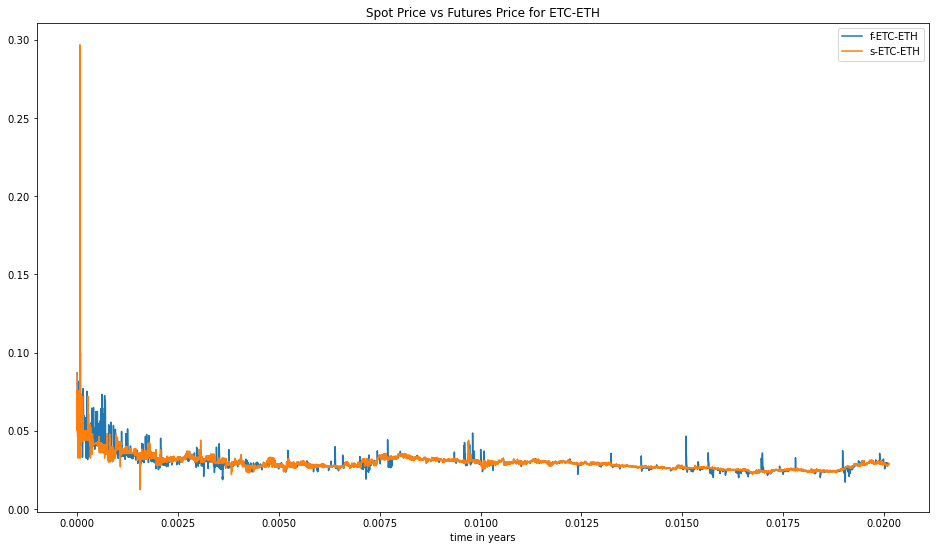

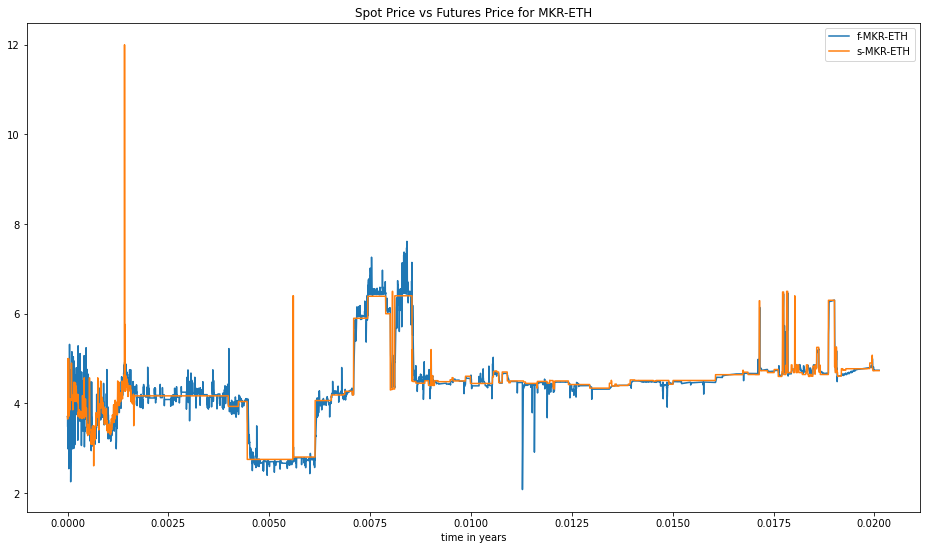

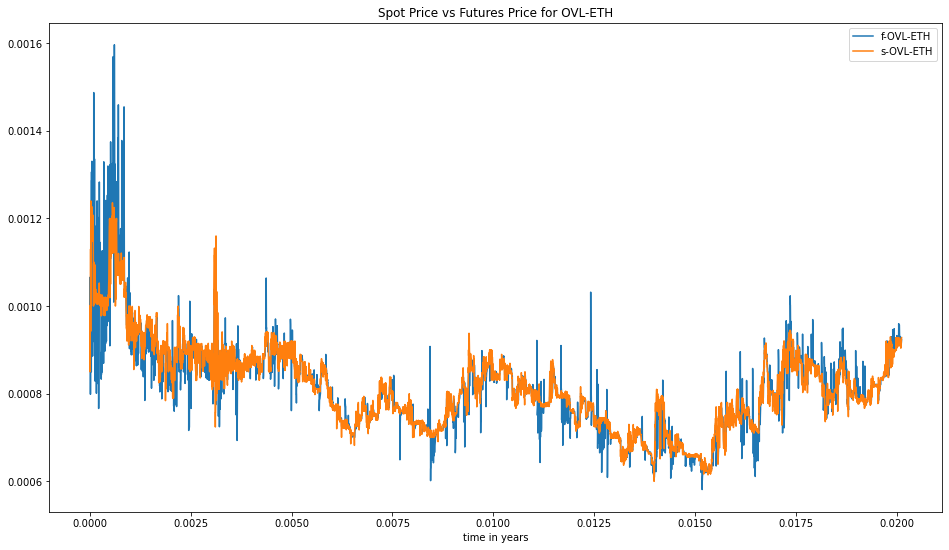

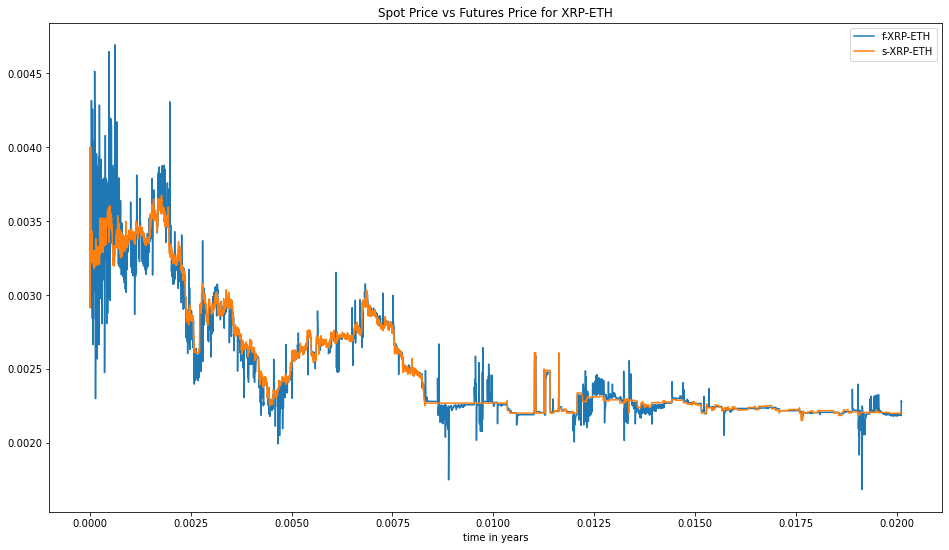

In [85]:
for i, ticker in enumerate(tickers_with_ovl):
    plot_spot_vs_futures_price(
        model_vars_df=model_vars_df, 
        ticker=ticker, 
        plot_time_scale=plot_time_scale, 
        time_resolution=time_resolution, 
        time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds, 
        data_interval=data_collection_options.data_collection_interval)

In [86]:
# model_vars_df.columns

In [87]:
# tickers_with_ovl[0]

In [88]:
# def plot_cumulative_spot_returns(
#         model_vars_df: pd.DataFrame,
#         ticker: str,
#         plot_time_scale: TimeScale,
#         time_resolution: TimeResolution,
#         time_interval_to_plot_in_seconds:
#         tp.Optional[tp.Tuple[tp.Optional[float], tp.Optional[float]]] = None,
#         figure_size: tp.Tuple[float, float] = DEFAULT_FIGURE_SIZE,
#         data_interval: int = 1,
#         # relative: bool = False
# ):
#     column_name_to_label_map = \
#         {spot_price_label(ticker): spot_price_label(ticker)}

#     plot_multiple_variables_over_time(
#         model_vars_df=model_vars_df,
#         column_name_to_label_map=column_name_to_label_map,
#         plot_time_scale=plot_time_scale,
#         time_resolution=time_resolution,
#         time_interval_to_plot_in_seconds=time_interval_to_plot_in_seconds,
#         figure_size=figure_size,
#         data_interval=data_interval)

#     plt.legend();
#     plt.title(f'Spot Price vs Futures Price for {ticker}')


In [89]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryLiquidator.scope_liquidations \
#     -f MonetaryLiquidator.step \
#     -f MonetarySniper._get_unwind_amount \
#     -f MonetarySniper._unwind_positions \
#     -f MonetarySniper._get_filled_price \
#     -f MonetarySniper._get_size \
#     -f MonetarySniper._get_effective_edge \
#     -f MonetarySniper.trade \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.slippage \
#     -f MonetaryFMarket.fund \
#     -f MonetaryFMarket.funding \
#     -f MonetaryFMarket.liquidatable \
#     -f MonetaryFMarket.liquidate \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [90]:
# plt.close('all')

# Load HDF5 Results

In [91]:
HDF5DataCollectionFile.available_hdf5_files()

['/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-19-07-16.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-16-14-57.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-18-40-17.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_07-02-2021-13-52-55.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-18-49-27.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-19-04-35.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-18-46-50.h5',
 '/Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_06-02-2021-15-04-14.h5',
 '/Volumes/GIT/PycharmPr

In [92]:
hdf5_data_collection_file = \
    HDF5DataCollectionFile(filepath=monetary_model.data_collector.hdf5_path)

In [93]:
hdf5_data_collection_file.get_model_dataframe()

,d-EOS-ETH,d-ETC-ETH,d-MKR-ETH,d-OVL-ETH,d-XRP-ETH,s-EOS-ETH,s-ETC-ETH,s-MKR-ETH,s-OVL-ETH,s-XRP-ETH,...,Reserve Skew XRP-ETH (% Difference),Number of Open Positions on EOS-ETH,Number of Open Positions on ETC-ETH,Number of Open Positions on MKR-ETH,Number of Open Positions on OVL-ETH,Number of Open Positions on XRP-ETH,Supply,Treasury,Liquidity,step
0,0.000000,-1.595148e-16,1.198317e-16,0.000000,1.239088e-16,0.027200,0.087000,3.70594,0.001000,0.003500,...,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0,0
1,0.813454,7.392695e-01,-5.743150e-04,0.176471,1.239088e-16,0.014999,0.050021,3.70807,0.000850,0.003500,...,0.000000,0,0,0,0,0,100000.000000,0.000000,28500.0,1
2,0.701636,4.500599e-01,-4.727926e-02,0.078656,2.806401e-01,0.014999,0.050020,3.65000,0.000988,0.002913,...,0.065712,1,1,1,1,1,99999.010418,0.989582,28500.0,2
3,0.874553,2.477458e-02,3.635085e-03,0.071711,1.992453e-01,0.012801,0.075880,3.70000,0.000931,0.002913,...,-0.002022,2,2,2,2,2,99998.297918,1.702082,28500.0,3
4,0.779721,1.493379e-01,-2.085565e-01,-0.050201,-1.805612e-01,0.012700,0.050203,5.00000,0.000986,0.004000,...,-0.063499,3,3,3,3,3,99996.977918,3.022082,28500.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10576,0.016752,-3.269995e-02,1.905276e-03,-0.007865,-6.460412e-03,0.013284,0.029349,4.73000,0.000920,0.002201,...,-0.383328,140,768,841,260,347,91880.722529,1930.321818,28500.0,10576
10577,0.037650,-2.155156e-02,1.905276e-03,-0.005105,3.782969e-02,0.013000,0.029352,4.73000,0.000920,0.002201,...,-0.358579,141,769,841,261,346,91874.655821,1931.144922,28500.0,10577
10578,0.035538,-6.239725e-03,1.905277e-03,-0.007505,3.680325e-02,0.013000,0.028900,4.73000,0.000927,0.002201,...,-0.359150,142,770,842,260,347,91873.995351,1931.171976,28500.0,10578
10579,0.008266,-5.465384e-03,1.905277e-03,-0.006686,3.631471e-02,0.013310,0.028899,4.73000,0.000928,0.002201,...,-0.359422,143,771,842,261,348,91873.982808,1931.184520,28500.0,10579


In [94]:
hdf5_data_collection_file.describe()

HDF5 Agent Based Simulation Result
HDF5 File Path = /Volumes/GIT/PycharmProjects/overlay-monetary/agent_based_simulation_output_data/MonetaryModel_07-02-2021-13-52-55.h5
Number of simulation steps = 10582
GIT_BRANCH = new_optimization_branch
GIT_COMMIT_HASH = 42415dab95842121382b735e8b2dba7366f6801b
base_liquidate_reward = 0.1
base_maintenance = 0.6
base_market_fee = 0.003
base_max_leverage = 10.0
base_wealth = 50.0
data_collection_interval = 1
historical_data_source = kucoin
is_resampled = None
liquidity = 28499.999999999996
num_arbitrageurs = 200
num_holders = 1000
num_keepers = 10
num_liquidators = 10
num_long_apes = 70
num_short_apes = 30
num_snipers = 100
num_traders = 10
numpy_seed = None
ovl_quote_ticker = OVL-ETH
ovl_ticker = SNX-ETH
quote_ticker = ETH
sampling_interval = 60
sampling_twap_granularity = 6
time_resolution = 1m
treasury = None


In [95]:
time_resolution_from_hdf5_file = hdf5_data_collection_file.get_model_level_parameter('time_resolution')
time_resolution_from_hdf5_file

'1m'

# Plot Model Level Variables from Stored HDF5 Results

# Plot Agent Level Variables from Stored HDF5 Results

In [96]:
hdf5_data_collection_file.agent_type_string_set

{'MonetaryApe',
 'MonetaryArbitrageur',
 'MonetaryHolder',
 'MonetaryKeeper',
 'MonetaryLiquidator',
 'MonetarySniper',
 'MonetaryTrader'}

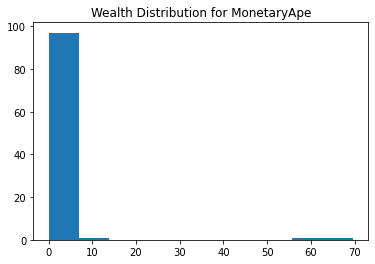

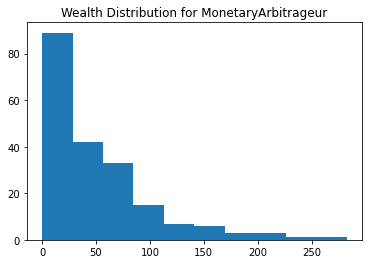

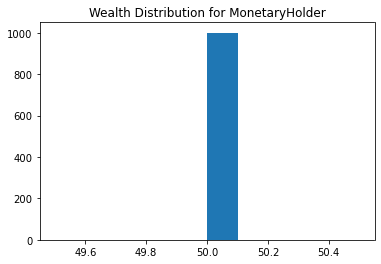

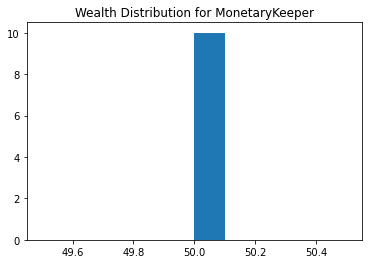

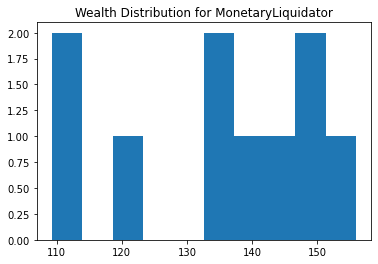

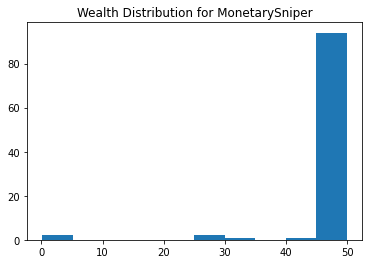

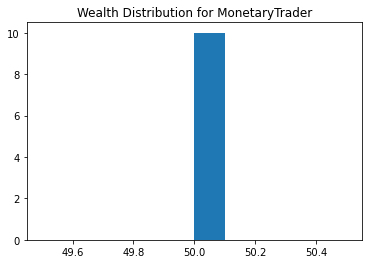

In [97]:
for agent_type_string in sorted(hdf5_data_collection_file.agent_type_string_set):
    wealth_df_for_agent_type = \
        hdf5_data_collection_file.get_agent_report_dataframe('Wealth', 
                                                             use_agent_types_in_header=True, 
                                                             agent_type_string=agent_type_string)
    plt.figure();
    plt.hist(wealth_df_for_agent_type.iloc[-1, :]);
    plt.title(f'Wealth Distribution for {agent_type_string}')